In [2]:
import os
import nltk
import nltk.tokenize
import re
import unidecode
import collections
import numpy as np
import csv
import matplotlib.pyplot as plt


In [3]:
nltk.download('punkt', quiet=True)

True

In [4]:
n = 50 # Choose a number for a song to inspect.

In [5]:
def read_data(csvfile):
	# Result: list (= row) of lists, without header.
	data = []
	headers = True
	with open(csvfile) as stream:
		reader = csv.reader(stream, delimiter=',')
		for row in reader:
			if not headers:
				data.append(row)

			headers = False

	return data

In [6]:
liedjesData = np.array(read_data('../../data/liedjes/liedjes.csv')) # create np.array to be able to order lexicographically
liedjesData = liedjesData[liedjesData[:, 1].argsort()] # order lexicographically on identifier just like the textlist
print(liedjesData[n])

['https://zotero.org/groups/2707622/items/I664294A' 'album1856-51'
 'Bij het standbeeld' "Henri's drinklied" '1856' 'H. Everts' 'tiel1852']


In [7]:
def getlistOfTexts(rootdir):
    # input: directory with (subdirectory with) TXT-files to be handled
	# output: list of files lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

liedjesList = getlistOfTexts('../../data/liedjes')

In [8]:
print(liedjesList[n])

../../data/liedjes/album1856/album1856-51.txt


In [9]:
def texts2list(listOfTexts):
	# input: list of files lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfTexts:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

liedjes = texts2list(liedjesList)

In [10]:
print(liedjes[n])

Bij het standbeeld.

Broeders ! vrienden! kunstgenooten!
Juicht bij 't opgerigte beeld ! 
Dat men heden zag ontblooten, 
En dat aller oogen streelt; 
Want de geest,
Op dit feest, 
Van vereende Typographen, 
Die oud-Hollands glorie staven,
Kan geen grooter vreugd geschiên, 
Nu zij COSTERS beeldtnis zien.
Vader LOUWTJE was te vreden,
Als hij kindren vrolijk zag ; 
Wij gaan hem nu tegentreden, 
Op deez' ware vreugde dag; 
En de bee,
Voert men mee, 
Om gestaag aan 't feest te denken, 
Onze eerbied hem te schenken, 
Daar zijn kunst het daaglijks brood, 
Broeders ! aan ons allen bood. 
Juicht dus allen , kunstgenooten!
Op deez' ware vreugde dag ; 
Wilt zijn naam op 't feest vergrooten , 
Dat gij heden vieren mag. 
U zij de Eer,
Hemelheer! 
Schenkt, wij bidden 't U, den zegen, 
Geeft ons voorspoed, allerwegen,
Leidt ons op een effen baan,
Laat ons daarop voorwaarts gaan. 



In [11]:
def is_punctuation(string):
	# Result: A boolean for being a punctuation mark or not
	return re.compile(r'[^\w\s]+$').match(string) is not None

def remove_diacritics(string):
	# Result: A string without diacritics (accents)
	return unidecode.unidecode(string)

def preprocess_text(string):
	# Result: list of tokens in a string (= "tokenized corpus")
	string = string.lower()
	tokens = nltk.tokenize.word_tokenize(string, language="dutch")
	tokens = [token for token in tokens if not is_punctuation(token)]
	tokens = [remove_diacritics(token) for token in tokens]

	return tokens

tokenized_liedjes = [preprocess_text(liedje) for liedje in liedjes]

In [12]:
print(tokenized_liedjes[n])

['bij', 'het', 'standbeeld', 'broeders', 'vrienden', 'kunstgenooten', 'juicht', 'bij', "'t", 'opgerigte', 'beeld', 'dat', 'men', 'heden', 'zag', 'ontblooten', 'en', 'dat', 'aller', 'oogen', 'streelt', 'want', 'de', 'geest', 'op', 'dit', 'feest', 'van', 'vereende', 'typographen', 'die', 'oud-hollands', 'glorie', 'staven', 'kan', 'geen', 'grooter', 'vreugd', 'geschien', 'nu', 'zij', 'costers', 'beeldtnis', 'zien', 'vader', 'louwtje', 'was', 'te', 'vreden', 'als', 'hij', 'kindren', 'vrolijk', 'zag', 'wij', 'gaan', 'hem', 'nu', 'tegentreden', 'op', 'deez', 'ware', 'vreugde', 'dag', 'en', 'de', 'bee', 'voert', 'men', 'mee', 'om', 'gestaag', 'aan', "'t", 'feest', 'te', 'denken', 'onze', 'eerbied', 'hem', 'te', 'schenken', 'daar', 'zijn', 'kunst', 'het', 'daaglijks', 'brood', 'broeders', 'aan', 'ons', 'allen', 'bood', 'juicht', 'dus', 'allen', 'kunstgenooten', 'op', 'deez', 'ware', 'vreugde', 'dag', 'wilt', 'zijn', 'naam', 'op', "'t", 'feest', 'vergrooten', 'dat', 'gij', 'heden', 'vieren', 'm

In [13]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

liedjesVocabulary = extract_vocabulary(tokenized_liedjes, min_count=2)

In [14]:
def corpus2dtm(tokenized_corpus, vocabulary):
	# Result: Document Term Matrix: 
	# rows being documents in tokenized_corpus, columns being the words in vocabulary, 
	# values being the count of the word in the document
	document_term_matrix = []
	for document in tokenized_corpus:
		document_counts = collections.Counter(document)
		row = [document_counts[word] for word in vocabulary]
		document_term_matrix.append(row)

	return document_term_matrix

dtm_liedjes = np.array(corpus2dtm(tokenized_liedjes, liedjesVocabulary))

In [15]:
for i in range(len(dtm_liedjes[n])):
    if dtm_liedjes[n][i] > 0:
        print(liedjesVocabulary[i],dtm_liedjes[n][i])

't 4
aan 2
allen 2
aller 1
allerwegen 1
als 1
baan 1
bee 1
beeld 1
beeldtnis 1
bidden 1
bij 2
bood 1
broeders 2
brood 1
costers 1
daaglijks 1
daar 1
daarop 1
dag 2
dat 3
de 3
deez 2
den 1
denken 1
die 1
dit 1
dus 1
een 1
eer 1
eerbied 1
en 2
feest 3
gaan 2
geeft 1
geen 1
geest 1
geschien 1
gestaag 1
gij 1
glorie 1
grooter 1
heden 2
hem 2
hemelheer 1
het 2
hij 1
juicht 2
kan 1
kindren 1
kunst 1
kunstgenooten 2
laat 1
leidt 1
louwtje 1
mag 1
mee 1
men 2
naam 1
nu 2
om 1
ons 4
onze 1
oogen 1
op 5
schenken 1
schenkt 1
standbeeld 1
staven 1
streelt 1
te 3
typographen 1
u 2
vader 1
van 1
vereende 1
vergrooten 1
vieren 1
voert 1
voorspoed 1
voorwaarts 1
vreugd 1
vreugde 2
vrienden 1
vrolijk 1
want 1
ware 2
was 1
wij 2
wilt 1
zag 2
zegen 1
zien 1
zij 2
zijn 2


In [16]:
document_distance_matrix = []
all_values = []
for i in range(len(liedjesList)):
    a = dtm_liedjes[i]
    row = []
    for j in range(len(liedjesList)):
        b = dtm_liedjes[j]
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        row.append(cos_sim)
        if cos_sim < 1:
            all_values.append(cos_sim)
    document_distance_matrix.append(row)


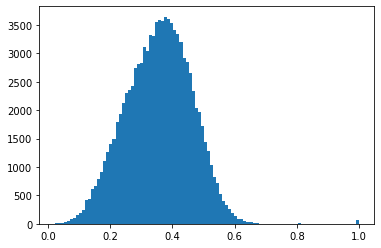

In [17]:
plt.hist(all_values, bins = 100)
plt.show()

In [18]:
for i in range(len(liedjesList)):
    for j in range(len(liedjesList)):
        if document_distance_matrix[i][j] > 0.9 and document_distance_matrix[i][j] < 0.99:
            print(document_distance_matrix[i][j])
            print(liedjesData[i])
            print(liedjesData[j])
            print("------------")


0.967424809912295
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-07'
 'TOT COSTERS EER' 'Wien Neerlands bloed' '1856' 'J.P. Bladergroen'
 'rotterdam1849']
['https://zotero.org/groups/2707622/items/F6DWAKEH'
 'middelburg1847-feestbundel1864-30b' 'Slotzang' 'Wien Neerlands bloed'
 '1854' '' 'middelburg1847']
------------
0.9696074074417983
['' 'haarlem1851-feestliederen1860-04' 'Coster’s Uitvinding'
 "Wie praalt aan 't hoofd der Heldenstoet" '1860' 'J.P. Nobels'
 'haarlem1851']
['' 'haarlem1851-iisgdossier-04' 'Coster’s uitvinding'
 "Wie praalt aan 't hoofd der Heldenstoet" '1853' '' 'haarlem1851']
------------
0.9807420569173149
['' 'haarlem1851-feestliederen1860-06' 'Vriendschap'
 'De vrolijke Visscher' '1860' 'W.' 'haarlem1851']
['https://zotero.org/groups/2707622/items/VL4IRLV2' 'reglement185?-03' ''
 '' '185?' '' '']
------------
0.9696074074417983
['' 'haarlem1851-iisgdossier-04' 'Coster’s uitvinding'
 "Wie praalt aan 't hoofd der Heldenstoet" '1853' '' 'haarlem1851

In [19]:
for i in range(len(liedjesList)):
    if document_distance_matrix[n][i] > 0.5:
        print(liedjesData[i])

['https://zotero.org/groups/2707622/items/I664294A' 'album1856-51'
 'Bij het standbeeld' "Henri's drinklied" '1856' 'H. Everts' 'tiel1852']
['https://zotero.org/groups/2707622/items/F6DWAKEH'
 'middelburg1847-feestbundel1864-19' 'Voorwaarts!'
 'Kom mijn bruintje stap wat aan' '1852' '' 'middelburg1847']
['https://zotero.org/groups/2707622/items/SGA2CMRR'
 'utrecht1851-feestzangen1854-17' 'DE TYPOGRAPHISCHE LEDEN'
 'Ge vergt me, dat ik zingen zal' '1854' 'J.H.C. Venman' 'utrecht1851']
['https://zotero.org/groups/2707622/items/SGA2CMRR'
 'utrecht1851-feestzangen1854-26' 'FEEST-MARSCH' 'Wij zijn lustig' '1854'
 'P.A. van Doorn' 'utrecht1851']
['https://zotero.org/groups/2707622/items/SGA2CMRR'
 'utrecht1851-feestzangen1854-27' 'FEEST-MARSCH'
 'Mijnheer Gordon is een brave kapitein' '1854' 'J.H.C. Venman'
 'utrecht1851']
